In [1]:
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from lib import plotting

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
env.observation_space.sample()

array([ 0.66873467,  0.42860916, -0.23476091, -0.46821624,  9.195841  ,
       16.711441  ], dtype=float32)

In [4]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))
# np.amin(observation_examples,axis=0)

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [5]:
class Function_Approximator():
    
    def __init__(self):
        
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
            
    
    def featurize_state(self, state):
        
        scaled = scaler.transform([state])
        features = featurizer.transform(scaled)
        return features[0]
    
    
    def predict(self, s, a=None):
        
        state_features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([state_features])[0] for m in self.models])
        else:
            return self.models[a].predict([state_features])[0]
        
    def update(self, s, a, y):
       
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [6]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [20]:
def sarsa(env, estimator, num_episodes, discount_factor=0.99, epsilon=0.1, epsilon_decay=1.0):
    
    alpha = 1
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Initialize 's'
        state = env.reset()
        

            
        for t in itertools.count():
            
            # Choose 'a' from 's' using policy derived from Q
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take action 'a' and observe r, s'
            next_state, reward, end, _ = env.step(action)
            env.render()
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Get Q(s,~)
            q_values_this = estimator.predict(state)
            
            # Get Q(s',~)
            q_values_next = estimator.predict(next_state)
            
            # [r + gamma*Q(s',a')]
            td_target = alpha*(reward + discount_factor * np.amax(q_values_next)) + (1-alpha)*q_values_this[action]
            
            # Update Q value
            estimator.update(state, action, td_target)
                
            if end:
                break
                
            state = next_state
            
        if (i_episode+1) % 10 == 0:
            avg_reward = np.sum(stats.episode_rewards[i_episode-10:i_episode])/10
            print("\rEpisode {}/{} Avg. reward = {}".format(i_episode + 1, num_episodes, avg_reward))
    
    return stats

In [21]:
estimator = Function_Approximator()

stats = sarsa(env, estimator, 500, epsilon=0.1)

Episode 10/500 Avg. reward = 0.0
Episode 20/500 Avg. reward = -267.8
Episode 30/500 Avg. reward = -245.0
Episode 40/500 Avg. reward = -230.2
Episode 50/500 Avg. reward = -202.9
Episode 60/500 Avg. reward = -205.9
Episode 70/500 Avg. reward = -190.1
Episode 80/500 Avg. reward = -195.7
Episode 90/500 Avg. reward = -156.1
Episode 100/500 Avg. reward = -205.7
Episode 110/500 Avg. reward = -138.2
Episode 120/500 Avg. reward = -136.7
Episode 130/500 Avg. reward = -142.3
Episode 140/500 Avg. reward = -146.4
Episode 150/500 Avg. reward = -127.7
Episode 160/500 Avg. reward = -200.6
Episode 170/500 Avg. reward = -116.3
Episode 180/500 Avg. reward = -113.0
Episode 190/500 Avg. reward = -128.7
Episode 200/500 Avg. reward = -111.2
Episode 210/500 Avg. reward = -171.4
Episode 220/500 Avg. reward = -167.7
Episode 230/500 Avg. reward = -117.5
Episode 240/500 Avg. reward = -119.3
Episode 250/500 Avg. reward = -169.4
Episode 260/500 Avg. reward = -150.1
Episode 270/500 Avg. reward = -139.4
Episode 280/5

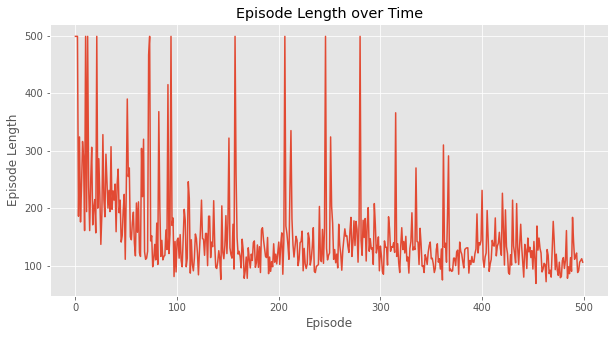

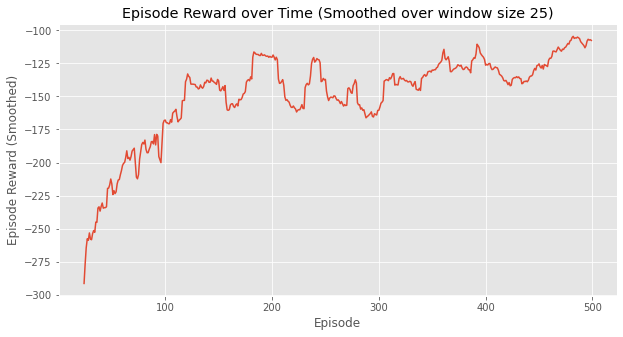

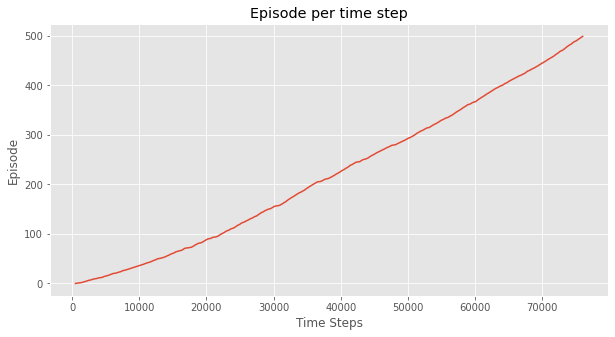

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [22]:
plotting.plot_episode_stats(stats, smoothing_window=25)

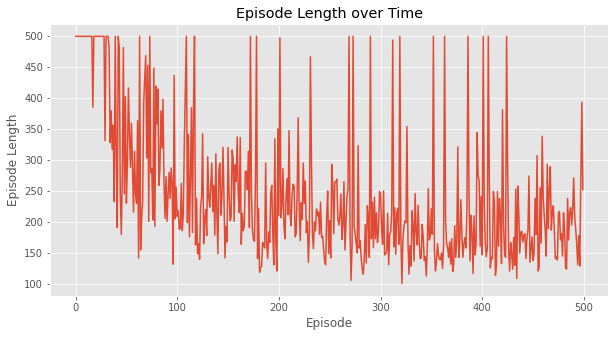

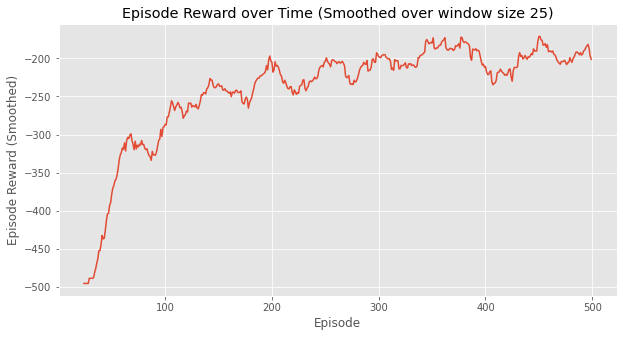

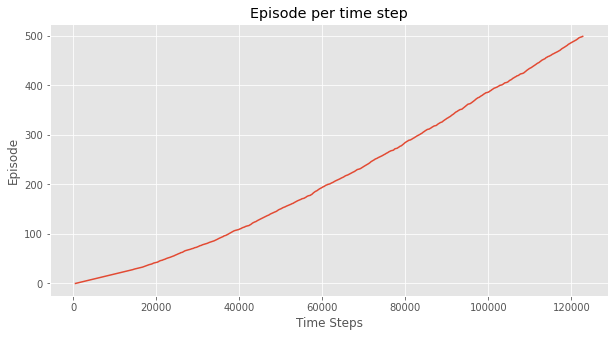

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [19]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [28]:
# state = env.observation_space.sample()
state = env.reset()
# plt.figure()
# plt.imshow(env.render(mode='rgb_array'))
while True:
    q_values = estimator.predict(state)
    best_action = np.argmax(q_values)
#     plt.figure()
#     plt.imshow(env.render(mode='rgb_array'))

#     action_pge = get_pge_action(best_action)
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render()
# env.close()

In [63]:
env.observation_space.sample()

array([-0.11945403,  0.29413375, -1.4568335 , -0.17493604,  0.40899193,
        0.73602676,  1.3300323 ,  0.1892223 ], dtype=float32)

In [31]:
env = gym.make('CartPole-v1')

In [61]:
env.reset()
env.step(env.action_space.sample())

(array([ 0.00353907,  0.19214232, -0.0343606 , -0.34522076]), 1.0, False, {})

In [123]:
env.step(env.action_space.sample())

(array([-0.74117499, -1.35688824,  0.28442935,  1.79704102]), 0.0, True, {})

In [29]:
env.close()